Эксперименты с распознаванием дефектов по Северстали

Лишние и несодержательные ячейки удалены, добавлены мои комментарии к внесенным изменениям

ссылка на каггл с этим соревнованием - https://www.kaggle.com/c/severstal-steel-defect-detection

### Постановка задачи :

Этот конкурс представляет собой двойной конкурс: классифицируйте тип дефекта стали, а также сегментируйте части изображения, содержащие дефект.



In [2]:
# загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout

In [3]:
data = pd.read_csv('./train.csv')
data.shape

(7095, 3)

# Разведочный анализ данных

ClassId
3    5150
1     897
4     801
2     247
Name: count, dtype: int64

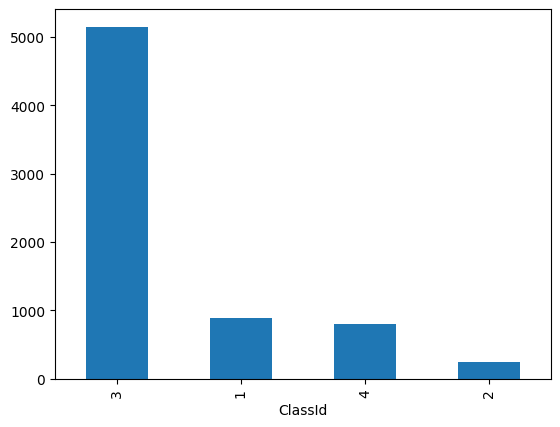

In [4]:
data["ClassId"].value_counts().plot(kind = 'bar')
data["ClassId"].value_counts()

больше всего меток третьего класса

Перекос данных, поэтому выполним аугментацию.

In [5]:
import cv2
import os.path

In [6]:
# на сайте ГБ неполный набор фото (всего 351 снимок из 7095), поэтому выкидываем лишние данные
# работаем только с имеющимися изображениями
l1=[]
l2=[]
for img,ClassId,EncodedPixels in tqdm(data.values):
    if os.path.exists("./train_images/{}".format(img)):
        image=cv2.imread("./train_images/{}".format(img),cv2.IMREAD_COLOR)
        l1.append(image)
        l2.append(ClassId)

100%|██████████| 7095/7095 [00:02<00:00, 2695.68it/s] 


In [7]:
len(l1)

351

Проверка изображений случайной стали, чтобы проверить, дефектна ли она или нет.

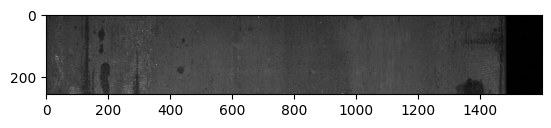

In [8]:
i = 350
plt.imshow(l1[i])

Выполним one-hot кодировку

In [9]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = np.array(y)


In [10]:
# итого имеем 351 изображение размером 256*1600 RGB
X.shape

(351, 256, 1600, 3)

In [11]:
y.shape

(351,)

# Борьба с дибалансом

для борьбы с дисбалансом выполним случайное сэмплирование

In [12]:
from imblearn.over_sampling import RandomOverSampler

reshaped_X = X.reshape(X.shape[0],-1)
reshaped_X.shape
oversample = RandomOverSampler(sampling_strategy='not majority')

X, y  = oversample.fit_resample(reshaped_X , y)

X.shape

(984, 1228800)

In [13]:
# в этом месте в оригинальном файле была ошибка с перешейпированием в размер 120*120*3
# я решил обучить сеть на исходных данных 256*1600
X = X.reshape(X.shape[0],256,1600,3)
X.shape

(984, 256, 1600, 3)

In [14]:

y = to_categorical(y)
y.shape

(984, 4)

разделим на тренировку и валидацию

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)

In [15]:
print("x_train размер:",X_train.shape)
print("x_test размер:",X_test.shape)
print("y_train размер:",y_train.shape)
print("y_test размер:",y_test.shape)

x_train размер: (787, 256, 1600, 3)
x_test размер: (197, 256, 1600, 3)
y_train размер: (787, 4)
y_test размер: (197, 4)


# Построение нейронной сети  в 3 слоя и график обучения

In [15]:
model=Sequential()
model.add(Conv2D(128,(3,3),input_shape=(256,1600,3),activation="relu"))
model.add(Flatten())
model.add(Dense(4,activation="softmax"))

c:\AIcode\4.Conv\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [17]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=50,
                    verbose=1)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 134s 8s/step - accuracy: 0.2844 - loss: 610.0728 - val_accuracy: 0.4162 - val_loss: 60.1658
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 125s 8s/step - accuracy: 0.4081 - loss: 31.4042 - val_accuracy: 0.6193 - val_loss: 1.5580
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 129s 8s/step - accuracy: 0.6604 - loss: 1.2237 - val_accuracy: 0.4416 - val_loss: 1.2314
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 131s 8s/step - accuracy: 0.7402 - loss: 1.0147 - val_accuracy: 0.8477 - val_loss: 0.6600
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 128s 8s/step - accuracy: 0.8985 - loss: 0.5396 - val_accuracy: 0.9036 - val_loss: 0.5616
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 129s 8s/step - accuracy: 0.9443 - loss: 0.2902 - val_accuracy: 0.8883 - val_loss: 0.4224
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 128s 8s/step - accuracy: 0.9401 - loss: 0.2158 - val_accuracy: 0.9036 - val_loss: 0.5465
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 128s 8s/step - accuracy: 0.9228 - loss: 0.3060 - val_accuracy: 0.8832

<Axes: title={'center': 'Loss curve'}>

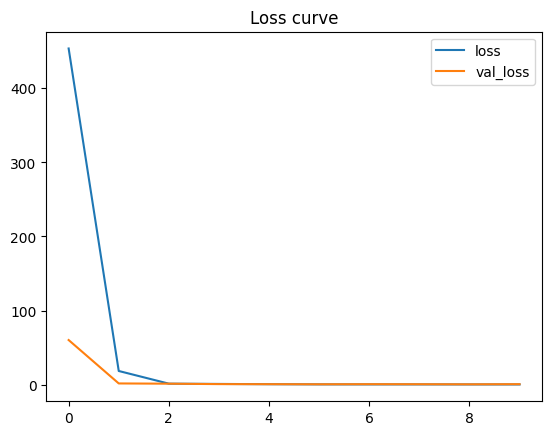

In [18]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

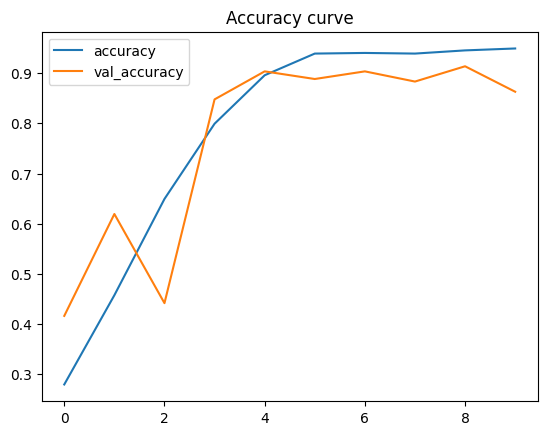

In [19]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [20]:
model.save('./model_steel_3_layers.keras')

result = model.evaluate(X_test, y_test)
loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

model.summary()

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 953ms/step - accuracy: 0.8689 - loss: 0.5398
[+] Accuracy: 86.29%


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 1598, 128) │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51954176)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │   207,816,708 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 623,460,878 (2.32 GB)

 Trainable params: 207,820,292 (792.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 415,640,586 (1.55 GB)

In [23]:
# освобождение памяти
#del model
#del history_df

#import gc
#gc.collect()

3833

# Построение нейронной сети  в 5 слоев

In [19]:
model=Sequential()
model.add(Conv2D(256,(3,3),input_shape=(256,1600,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(32,activation="relu"))
model.add(Dense(4,activation="softmax"))


In [20]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [21]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=50,
                    verbose=1)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 271s 17s/step - accuracy: 0.2915 - loss: 95.7063 - val_accuracy: 0.3401 - val_loss: 1.7755
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 269s 17s/step - accuracy: 0.4127 - loss: 1.4504 - val_accuracy: 0.6244 - val_loss: 0.7891
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 269s 17s/step - accuracy: 0.6775 - loss: 0.8693 - val_accuracy: 0.7970 - val_loss: 0.5780
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 266s 17s/step - accuracy: 0.8444 - loss: 0.4468 - val_accuracy: 0.8782 - val_loss: 0.3502
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 267s 17s/step - accuracy: 0.8949 - loss: 0.3028 - val_accuracy: 0.9036 - val_loss: 0.3609
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 269s 17s/step - accuracy: 0.9264 - loss: 0.2164 - val_accuracy: 0.8274 - val_loss: 0.5154
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 270s 17s/step - accuracy: 0.9261 - loss: 0.2671 - val_accuracy: 0.9239 - val_loss: 0.3295
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 267s 17s/step - accuracy: 0.9407 - loss: 0.2637 - val_accuracy: 0

<Axes: title={'center': 'Loss curve'}>

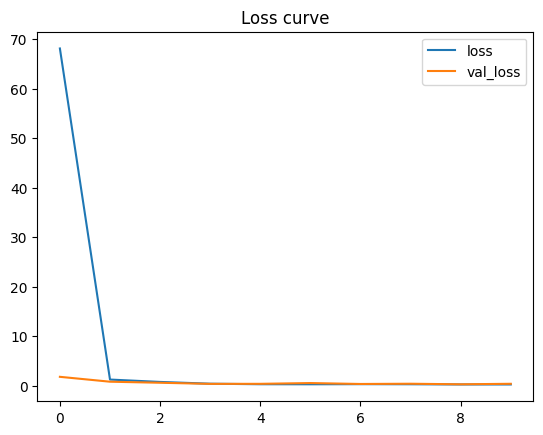

In [22]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

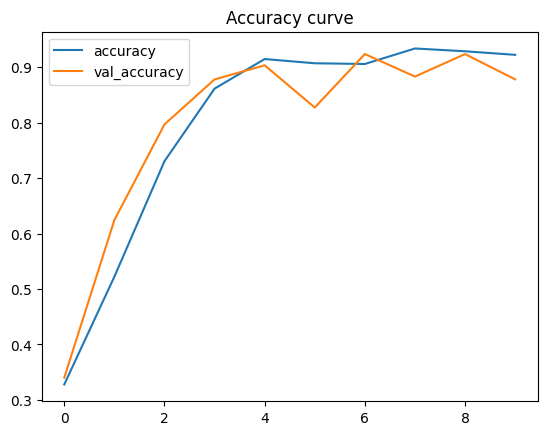

In [23]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [24]:
model.save('./model_steel_5_layers.keras')

result = model.evaluate(X_test, y_test)
loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

model.summary()

7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8706 - loss: 0.3331
[+] Accuracy: 87.82%


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 254, 1598, 256) │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 84, 532, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 11440128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │   366,084,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,098,274,286 (4.09 GB)

 Trainable params: 366,091,428 (1.36 GB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 732,182,858 (2.73 GB)

In [ ]:
# освобождение памяти
#del model
#del history_df

#import gc
#gc.collect()

# Построение нейронной сети в 13 слоев и обучение

In [25]:
model=Sequential()
model.add(Conv2D(128,(3,3),input_shape=(256,1600,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))

c:\AIcode\4.Conv\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Сборка и обучение модели

In [26]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [27]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=50,
                    verbose=1)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 206s 13s/step - accuracy: 0.2934 - loss: 1.3663 - val_accuracy: 0.3756 - val_loss: 1.2479
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 205s 13s/step - accuracy: 0.4246 - loss: 1.2045 - val_accuracy: 0.3959 - val_loss: 1.0468
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 209s 13s/step - accuracy: 0.4362 - loss: 1.1018 - val_accuracy: 0.5025 - val_loss: 1.0277
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 201s 13s/step - accuracy: 0.5270 - loss: 1.0067 - val_accuracy: 0.5990 - val_loss: 0.8897
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 201s 13s/step - accuracy: 0.5521 - loss: 0.9076 - val_accuracy: 0.6041 - val_loss: 0.8119
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 204s 13s/step - accuracy: 0.5990 - loss: 0.8399 - val_accuracy: 0.6751 - val_loss: 0.7238
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 203s 13s/step - accuracy: 0.7181 - loss: 0.6761 - val_accuracy: 0.7411 - val_loss: 0.6373
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 200s 12s/step - accuracy: 0.7578 - loss: 0.5852 - val_accuracy: 0.

In [28]:
model.save('./model_steel_13.keras')

result = model.evaluate(X_test, y_test)
loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

model.summary()

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8053 - loss: 0.4773
[+] Accuracy: 80.71%


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 254, 1598, 128) │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 84, 532, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 82, 530, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 27, 176, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 174, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 43, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16512)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,113,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,835,598 (26.08 MB)

 Trainable params: 2,278,532 (8.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,557,066 (17.38 MB)

# Анализ результатов обучения

<Axes: title={'center': 'Loss curve'}>

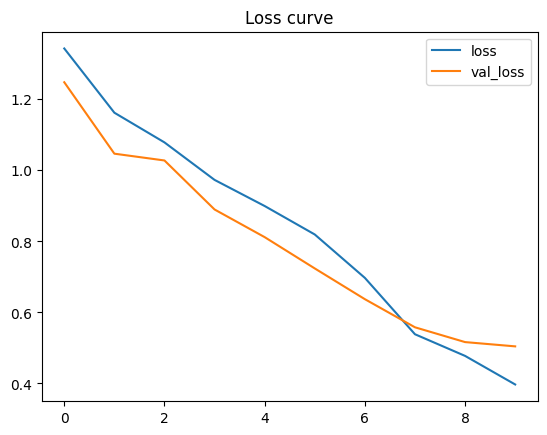

In [29]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

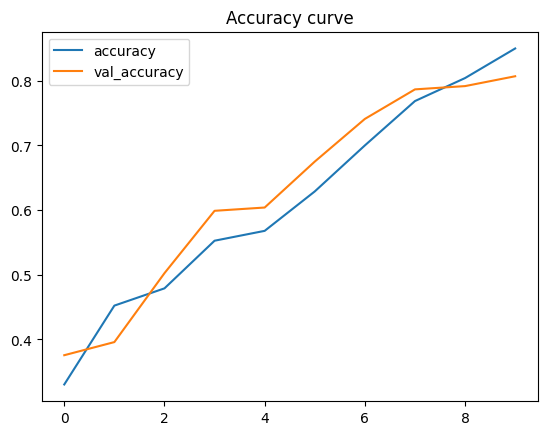

In [30]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [31]:
from keras.models import load_model

loaded_model = load_model('./model_steel_13.keras')


# Архитектура созданной нейронной сети

In [32]:
loaded_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 254, 1598, 128) │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 84, 532, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 82, 530, 64)    │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 27, 176, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 174, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 43, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16512)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,113,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,835,598 (26.08 MB)

 Trainable params: 2,278,532 (8.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,557,066 (17.38 MB)

# ИТОГО

модифицированы три исходные модели с 3, 5 и 13 слоями.
модель с 5 слоями показала большую точность, чем модель с 13 слоями. это вызвано малым количеством нейронов в слоях сети последней модели и, в первую очередь, в первом сверточном слое, что приводит к потере большого кол-ва исходных данных.
также входные изображения могут быть сконвертированы из RGB в черно-белый формат без существенного снижения точности распознавания дефектов. это приведет к снижению объема используемой памяти, в среднем, в 3 раза и пропорциональному сокращению времени расчета.